## Проект по курсу "Наука о данных"

**Что делает данный проект?**

По выбранным польльзователем жанрам находит фильмы с наилучшими рейтингами с IMDb, Rotten Tomatoes и Metacritic. Кроме жанров пользователь может выбрать количество и минимальный рейтинг фильмов в выдаче. По результатам выдаётся таблица с данными о фильмах с небольшими свистелками и графики со статистикой.

**Как это работает?**

Программа собирает список жанров с сайта IMDb и выдаёт их пользователю, преобразуя в Data Frame для хранения и HTML для вывода на экран. Пользователь выбирает нужные жанры, количество и рейтинг фильмов. Программа отправляет запрос пользователя и на сайте IMDb с использованием Beautiful Soup и Selenium достаёт информацию о фильмах. Чтобы получить данные по оценкам используется OMDB API, из которого также достаётся и часть остальных данных. Рейтинг считается с использованием библиотеки numpy. Кроме того, на сайте IMDb берётся ссылка на постер и количество голосов, которые добавляются в итоговую таблицу. Итоговая таблица преобразуется в HTML для более приятного вывода (включая картинку постера, кликабельные ссылки и т.п.). Так же кроме таблицы выводятся два графика о полученных результатах, построенные с помощью библиотеки Seaborn. Информацию о каждой функции смотрите в комментариях к коду

**Для запуска программы нужно сделать следующее:**

1. Запустить все ячейки кроме последней по порядку
2. Следовать инструкциям на экране

**Внимание!** Если появится ошибка вида "executable needs to be in PATH", вам надо будет скачать файл по ссылке из ошибки и либо положить в папку с программой, либо дописать путь к нему в помеченную строчку (**строка 44**) второй ячейки. Если вы хотите использовать не Chrome, вам надо будет вписать свой браузер в коде функции **get_next_url_and_html**

**О последней ячейке**

Так же я написал телеграм-бота, который даёт возможность воспользоваться урезанным функционалом моей программы. По выбранным жанрам он выдаёт вам один лучший фильм. В последней ячейке лежит его код, из которого я убрал код для доступа к запуску бота. Его запускать не надо, я добавил его в этот файл чтобы проверяющий мог посмотреть как я реализовал бота. Для его проверки напишите боту по ссылке http://t.me/film_search_project_bot или найдите в поиске телеграма @film_search_project_bot . Для его работы он должен быть запущен у меня, поэтому возможно он будет иногда недоступен, но я постараюсь держать его включенным по вечерам.

In [8]:
# Импортирую необходимые библиотеки
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
from IPython.display import Image, HTML, clear_output
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from selenium import webdriver
import math
from selenium.webdriver import Chrome
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Достаю список жанров с IMDb
def get_list_of_genres():
    url = "https://www.imdb.com/search/title"
    r = requests.get(url)
    page = bs(r.text)
    labels = page.findAll('label')
    genres = []
    for label in labels:
        if 'genres' in str(label):
            genres.append(label.text)
    return genres

        
# Вывожу несколько датафреймов в один ряд (используется для более удобного списка жанров)    
def make_dataframes_inline(dataframes):
    html = ''
    for dataframe in dataframes:
        html = html + dataframe.to_html(index = False, escape = False)
    html = html.replace('table','table style="display:inline; \n margin-right: 10px"')
    return html

# Вывожу на экран список жанров
def print_genres(genres):
    genres = ['Stop choice'] + genres
    genres_dict = {}
    for i, genre in enumerate(genres, 0):
        genres_dict[i] = genre
    genres_groups = []
    for i in range(math.floor(len(genres)/7)+1):
        genres_groups.append(pd.DataFrame(columns = ['Number', 'Genre']))
        for j in range(7):
            num = 7 * i + j
            if num < len(genres):
                genres_groups[i] = genres_groups[i].append({'Number':num, 'Genre':genres_dict[num]}, ignore_index = True)
            else:
                break
    html = make_dataframes_inline(genres_groups)
    display(HTML(html))
    return genres_dict

# Использую Selenium для переходов по сайту IMDb
def get_next_url_and_html(url):
    # В строчке ниже впишите путь к драйверу в кавычках
    browser = webdriver.Chrome()
    browser.get(url)
    try:
        next_button = browser.find_element_by_link_text('Next »')
        next_button.click()
        ans = {}
        ans['html'] = browser.page_source
        ans['url'] = browser.current_url
        browser.close()
        return ans
    except NoSuchElementException:
        browser.close()
        ans = {}
        ans['html'] = -1
        return ans
        
# Ищу подходящие фильмы на сайте IMDb
def search_imdb(genres, number, minimal_rating):
    genres_str = ''
    for genre in genres:
        genres_str = genres_str + str(genre) + ','
    genres_str = genres_str.lower()[:-1]
    url="https://www.imdb.com/search/title"
    params = {'title_type':'feature,tv_movie,tv_series,tv_special,tv_miniseries,documentary,short,video,tv_short', 'num_votes':'1000,', 'genres':genres_str, 'sort':'user_rating,desc'}
    request = requests.get(url, params=params)
    url =request.url
    movies_rating = {}
    page = bs(request.text, "html.parser")
    max_iterations = math.ceil(number/5)
    iterations_num = 0
    while len(movies_rating) < number and iterations_num < max_iterations:
        movie_there = False
        movies = page.findAll(class_='lister-item-content')
        ids = []
        for movie in movies:
            tag = movie.find('h3').a['href']
            ids.append(tag[tag.find('tt'):tag.find('/?ref')])
        for id_ in ids:
            movie = get_movie_by_id(id_)
            all_ratings = get_ratings(movie)
            rating = count_rating(all_ratings)
            if rating != -1 and rating >= minimal_rating:
                movies_rating[id_] = [rating, all_ratings, movie]
                movie_there = True
            finished = len(movies_rating) == number
            if finished:
                break
        if not(movie_there):
            break
        if not(finished):
            selen_next = get_next_url_and_html(url)
            if selen_next['html'] == -1:
                break
            next_html, url = selen_next['html'], selen_next['url']
            page = bs(next_html, "html.parser")
            iterations_num+=1
    return movies_rating

# Получаю данные о нужном фильме через OMDB API
def get_movie_by_id(id_):
    url = "http://www.omdbapi.com/"
    params = {'i':id_, 'plot':'short', 'r':'json', 'apikey':'adcbcaa5'}
    g=requests.get(url, params=params)
    return g.json()

# Достаю данные о рейтинге фильма с разных сайтов
def get_ratings(movie):
    results = np.array([0, 0, 0])
    results_there = np.array([False, True, True])
    try:
        ratings = movie['Ratings']
        for rating in ratings:
            if rating['Source'] == 'Rotten Tomatoes':
                results[0] = int(rating['Value'].replace('%', ''))/10
                results_there[0] = True
    except KeyError:
        results_there[0] = False
    try:
        results[1] = float(movie['imdbRating'])
    except (ValueError, KeyError):
        results_there[1] = False
    try:
        results[2] = int(movie['Metascore'])/10
    except (ValueError, KeyError):
        results_there[2] = False
    return np.array([results, results_there])

# Считаю общий рейтинг фильма
def count_rating(ratings):
    sum_ = np.sum(ratings[0])
    count = np.sum(ratings[1])
    if count == 0:
        return -1
    else:
        return sum_/count
    
# Слеюдующие 4 функции разбирают страницу фильма на сайте IMDb и возвращают информацию, указанную в названии функции    
def get_runtime_by_id(id_):
    url = "https://www.imdb.com/title/" + id_
    r = requests.get(url)
    page = bs(r.text)
    time_bad_format = page.time.text
    time = time_bad_format.replace('\n', '').replace(' ', '').replace('min', ' min')
    return time    

def get_votes_by_id(id_):
    url = "https://www.imdb.com/title/" + id_
    r = requests.get(url)
    page = bs(r.text)
    return time 

def get_poster_by_id(id_):
    url = "https://www.imdb.com/title/" + id_
    r = requests.get(url)
    page = bs(r.text)
    poster = page.find(class_='poster')
    poster_url = poster.find('img')['src']
    return poster_url

def get_votes_by_id(id_):
    url = "https://www.imdb.com/title/" + id_
    r = requests.get(url)
    page = bs(r.text)
    return int(page.find(itemprop = 'ratingCount').text.replace(',', ''))
    
# Создаю таблицу с информацией о фильмах    
def create_info_movies(movies):
    table = pd.DataFrame(columns = ['Poster', 'Title', 'Type', 'Year', 'Runtime', 'Rating', 'Votes', 'URL', 'Plot'])
    pd.set_option('display.max_colwidth', -1)
    for movie in movies:
        current = movies[movie][2]
        rating = round(movies[movie][0], 2)
        title = current['Title']
        type_ = current['Type'].capitalize()
        year = current['Year']
        runtime = current['Runtime']
        plot = current['Plot']
        votes = get_votes_by_id(movie)
        if plot == 'N/A':
            plot = 'No information'
        url = 'https://www.imdb.com/title/' + movie
        if runtime == 'N/A':
            try:
                runtime = get_runtime_by_id(movie)
            except AttributeError:
                runtime = 'No information'
        try:
            poster_url = get_poster_by_id(movie)
        except AttributeError:
            poster_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/ac/No_image_available.svg/300px-No_image_available.svg.png"
        
        table = table.append({'Title':title, 'Type':type_, 'Year':year, 'Runtime':runtime, 'Rating':rating, 'Votes':votes, 'Poster':poster_url, 'Plot':plot, 'URL':url}, ignore_index=True)
    table = table.sort_values(by=['Rating', 'Votes'], ascending=False).reset_index().drop('index', axis = 1)
    table.index += 1
    table.insert(0, 'Number', table.index)
    return table

# Вызываю функции для вывода всей информации на экран
def visualize(movie_table):
    movie_table = create_info_movies(movie_table)
    clear_output()
    print_table(movie_table)
    draw_graphs(movie_table)

# Перевожу таблицу в HTML для более приятного отображения
def print_table(movie_table):
    if len(movie_table) == 0:
        print('Отсутствуют фильмы, подходящие под ваш запрос')
    else:
        html = movie_table.to_html(index=False, escape = False, formatters = dict(Poster = path_to_image_html, 
                                                            Number = bold_html, URL = clickable_url))
        display(HTML(html))
                
# Следующие три функции преобразуют части таблицы в HTML, чтобы вывести их в более интересном формате            
def path_to_image_html(path):
    return '<img src="'+ path + '" width="100" >'

def bold_html(text):
    return '<h4> <b>' + str(text) + '</b> </h4>'

def clickable_url(url):
    return '<a href="' + url + '" target="_blank">' +  'IMDb page' + '</a>'

# Использую Seaborn чтобы нарисовать графики с рейтингами и количеством голосов фильмов
def draw_graphs(movie_table):
    if len(movie_table) == 0:
        return
    sns.set(style="dark", context="talk")
    if len(movie_table) > 15:
        graph, plots = plt.subplots(1, 2)
        sns.barplot(data = movie_table, palette='RdPu', x='Number', y='Votes', ax = plots[1])
        sns.barplot(data = movie_table, palette='RdPu', x='Number', y='Rating', ax = plots[0])
        if np.amax(movie_table['Votes']) / np.amin(movie_table['Votes']) > 10:
            plots[1].set_yscale('log')
        else:
            plots[1].set_ylim([np.amin(movie_table['Votes'])*0.8, np.amax(movie_table['Votes'])*1.05])
        plots[0].set_ylim([np.amin(movie_table['Rating'])*0.8, np.amax(movie_table['Rating'])*1.05])
        graph.set_size_inches(12, 5)
        graph.tight_layout()
        graph.show()
    else:
        plot1 = sns.barplot(data = movie_table, palette='RdPu', x='Number', y='Rating')
        plot1.set_ylim([np.amin(movie_table['Rating'])*0.8, np.amax(movie_table['Rating'])*1.05])
        lim_diff = -np.amin(movie_table['Rating'])*0.8 + np.amax(movie_table['Rating'])*1.05
        figure = plt.gcf()
        figure.set_size_inches(12, 5)
        plt.show()
        plot2 = sns.barplot(data = movie_table, palette='RdPu', x='Number', y='Votes')
        if np.amax(movie_table['Votes']) / np.amin(movie_table['Votes']) > 10:
            plot2.set_yscale('log')
        else:
            plot2.set_ylim([np.amin(movie_table['Votes'])*0.8, np.amax(movie_table['Votes'])*1.05])
        lim_diff = -np.amin(movie_table['Votes'])*0.8 + np.amax(movie_table['Votes'])*1.05
        figure = plt.gcf()
        figure.set_size_inches(12, 5)
        plt.show()

  

In [10]:
# Функция обрабатывающая запросы пользователя и вызывающая остальные функции для работы программы
def start():
    chosen_genres = []
    inp = -1
    genres = get_list_of_genres()
    while inp != 0:
        print('Введите номер жанра из списка ниже \nВведите 0, если вы хотите завершить выбор жанров')
        genres_dict = print_genres(genres)
        try:
            inp = int(input())
            if inp != 0:
                try:
                    genre = genres_dict[inp]
                    if not(genre in chosen_genres):
                        chosen_genres.append(genre)
                        chosen_genres.sort()
                    clear_output()
                except KeyError:
                    clear_output()
                    print('Жанра с таким номером нет')
            if len(chosen_genres) != 0:
                print('Выбранные жанры:', str(chosen_genres)[1:-1])
        except ValueError:
            clear_output()
            print('Номер жанра должен быть числом')
    if len(chosen_genres) == 0:    
        print('Вы не выбрали жанры')
        return
    print('Сколько фильмов найти?')
    try:
        num = int(input())
    except ValueError:
        print('Количество фильмов должно быть положительным числом')
        return
    if num <= 0:
        print('Количество фильмов должно быть больше 0')
        return
    else:
        try:
            minimal_rating = float(input('Какой минимальный рейтинг должен быть у фильма (шкала от 0 до 10)? \nЕсли не хотите ограничений, введите что угодно \n'))
        except ValueError:
            minimal_rating = 0
        print('Ожидайте результатов, это может занять некоторое время')
        display(HTML('<img width="400" align="center" src="https://www.demilked.com/magazine/wp-content/uploads/2016/06/gif-animations-replace-loading-screen-14.gif">'))
        visualize(search_imdb(chosen_genres, num, minimal_rating))

Number,Poster,Title,Type,Year,Runtime,Rating,Votes,URL,Plot
1,,Rick and Morty,Series,2013–,23 min,9.0,260141,IMDb page,An animated series that follows the exploits of a super scientist and his not-so-bright grandson.
2,,Vader: A Star Wars Theory Fan Series,Series,2018–,16 min,9.0,4200,IMDb page,Darth Vader fights between losing Padmé and serving the new master who promised to save her.
3,,The Cheat,Series,2017–,20 min,9.0,2927,IMDb page,Felix is a software developer who works for the department of software at an important anti-virus company. Beside that he is completing the missing parts of software on the games which are ...
4,,Legend of the Galactic Heroes,Series,1988–,25 min,9.0,1545,IMDb page,"Various people, especially two rising commanders, cope with a massive continual space conflict between two interstellar nations."
5,,The Web,Movie,2013,3 min,9.0,1125,IMDb page,"Microsoft Founder Bill Gates has implanted computer chips into asteroids in a diabolical scheme, and one hacker must stop him."


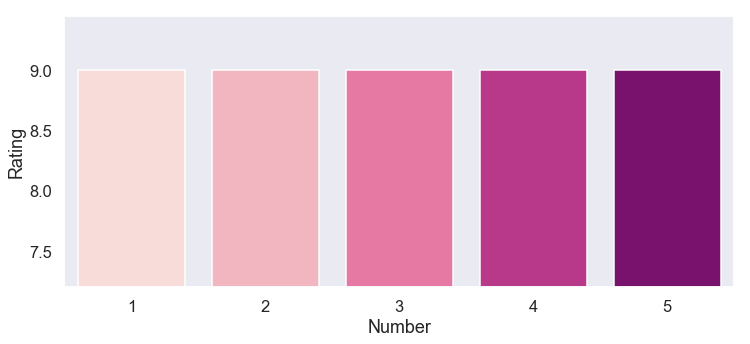

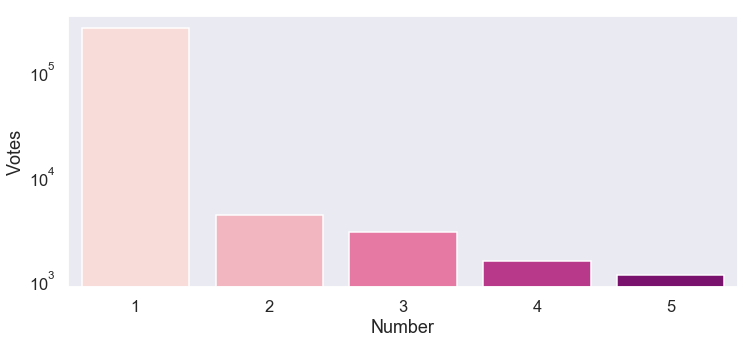

In [12]:
# Вызов функции запускающей программу
start()

In [7]:
import telebot;
from telebot import types
bot = telebot.TeleBot('здесь был код');

genres = []
film_num = -1
chosen_genres = []

@bot.message_handler(content_types=['text'])
def start(message):
    global genres
    genres = get_list_of_genres()
    bot.send_message(message.from_user.id, create_genres_output(genres) + 
                     '\nВведите номер жанра из списка ниже \nВведите 0, если вы хотите завершить выбор жанров')
    bot.register_next_step_handler(message, get_genre)
        
def get_genre(message):
    if message.text != '0':
        global chosen_genres
        genres_dict = print_genres(genres)
        try:
            inp = int(message.text)
            if inp != 0:
                try:
                    genre = genres_dict[inp]
                    if not(genre in chosen_genres):
                        chosen_genres.append(genre)
                        chosen_genres.sort()
                except KeyError:
                    bot.send_message(message.from_user.id, 'Жанра с таким номером нет')
            if len(chosen_genres) != 0:
                bot.send_message(message.from_user.id, 'Выбранные жанры: ' + str(chosen_genres)[1:-1])
                bot.send_message(message.from_user.id, create_genres_output(genres) + 
                     '\nВведите номер жанра из списка ниже \nВведите 0, если вы хотите завершить выбор жанров')
        except Exception:
            bot.send_message(message.from_user.id, "Введите целое число")
        bot.register_next_step_handler(message, get_genre)
    else:
        send_movie(chosen_genres, message.from_user.id)
        restart(message, message.from_user.id)
        
def restart(message, user):
    global genres, film_num, chosen_genres
    genres = []
    film_num = -1
    chosen_genres = []
    bot.send_message(user, 'Если вы хотите повторить, отправьте боту любое сообщение')
    bot.register_next_step_handler(message, start)
    
def send_movie(chosen_genres, user):
    movies = search_imdb(chosen_genres, 1, 0)
    if len(movies) == 0:
        bot.send_message(user, 'Отсутствуют фильмы, подходящие под ваш запрос')
        return
    for i in movies:
        movie = movies[i][2]
        rating = round(movies[i][0], 2)
        url = 'https://www.imdb.com/title/' + i
    title = movie['Title']
    year = movie['Year']
    bot.send_message(user, title + ' (' + str(year) + ')' +  '\nRating: ' + str(rating) + '\nLink: ' + url)
    
def create_genres_output(genres):
    text = ''
    for i, genre in enumerate(genres, 1):
        text = text + str(i) + ') ' + genre + '\n'
    return text

bot.polling(none_stop=True, interval=0)